# Analyse Dataset Diabetes avec Redis

Ce notebook analyse le dataset Diabetes en utilisant Redis comme base de données NoSQL pour le stockage et l'analyse des données médicales.

## Objectifs:
- Connecter et configurer Redis
- Charger et explorer le dataset Diabetes
- Implémenter des opérations CRUD avec Redis
- Effectuer des analyses statistiques sur les facteurs de risque du diabète
- Créer des visualisations pour identifier les patterns

## 1. Installation des Bibliothèques Requises

Nous allons installer et importer toutes les bibliothèques nécessaires pour notre analyse.

In [2]:
!pip install redis



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install matplotlib


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.1 MB 6.5 MB/s eta 0:00:02
   ------ --------------------------------- 1.3/8.1 MB 4.5 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/8.1 MB 4.9 MB/s eta 0:00:02
   ----------------------------- ---------- 6.0/8.1 MB 7.6 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 8.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 17.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
!pip install seaborn



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
!pip install plotly


   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 4.3 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/9.8 MB 4.3 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/9.8 MB 4.3 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/9.8 MB 4.3 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/9.8 MB 4.3 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/9.8 MB 441.3 kB/s eta 0:00:21
   --------- ------------------------------ 2.4/9.8 MB 1.5 MB/s eta 0:00:05
   ----------------- ---------------------- 4.2/9.8 MB 2.4 MB/s eta 0:00:03
   ------------------- -------------------- 4.7/9.8 MB 2.4 MB/s eta 0:00:03
   ------------------- -------------------- 4.7/9.8 MB 2.4 MB/s eta 0:00:03
   -------------------- ------------------- 5.0/9.8 MB 2.1 MB/s eta 0:00:03
   -------------------- ------------------- 5.0/9.8 MB 2.1 MB/s eta 0:00:03
   --------------


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
# Installation des packages (si nécessaire)
import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Décommentez si vous devez installer les packages
# install('redis')
# install('pandas')
# install('matplotlib')
# install('seaborn')
# install('plotly')

# Import des bibliothèques
import redis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import json
import warnings
warnings.filterwarnings('ignore')

print("Toutes les bibliothèques ont été importées avec succès!")

Toutes les bibliothèques ont été importées avec succès!


## 2. Configuration de la Connexion Redis

Nous allons établir une connexion avec notre instance Redis Stack qui fonctionne sur le port 6379.

In [33]:
# Configuration de la connexion Redis
try:
    # Connexion à Redis (Redis Stack sur localhost:6379)
    r = redis.Redis(
        host='localhost',
        port=6379,
        decode_responses=True,  # Pour décoder les réponses en UTF-8
        db=0
    )
    
    # Test de connexion
    response = r.ping()
    if response:
        print("Connexion Redis établie avec succès!")
        print(f"Redis version: {r.info()['redis_version']}")
    else:
        print("Problème de connexion Redis")
        
except redis.ConnectionError as e:
    print(f"Erreur de connexion: {e}")
    print("Assurez-vous que Redis Stack est en cours d'exécution sur le port 6379")

# Fonction utilitaire pour vérifier la connexion
def check_redis_connection():
    try:
        return r.ping()
    except:
        return False

Connexion Redis établie avec succès!
Redis version: 7.4.5


## 3. Chargement et Exploration du Dataset Diabetes

Chargeons le dataset Diabetes depuis: https://www.kaggle.com/datasets/mathchi/diabetes-data-set

In [34]:
# Chargement du dataset Diabetes
csv_path = "diabetes.csv"

try:
    # Chargement des données
    df = pd.read_csv(csv_path)
    print(f"Dataset Diabetes chargé avec succès!")
    print(f"Taille du dataset: {df.shape[0]} patients, {df.shape[1]} variables")
    
    # Affichage des premières lignes
    print("\nAperçu des données:")
    display(df.head())
    
    # Informations sur le dataset
    print("\nInformations sur les colonnes:")
    print(df.info())
    
    # Description des variables
    print("\nDescription des variables:")
    descriptions = {
        'Pregnancies': 'Nombre de grossesses',
        'Glucose': 'Concentration de glucose plasmatique',
        'BloodPressure': 'Pression artérielle diastolique (mm Hg)',
        'SkinThickness': 'Épaisseur du pli cutané tricipital (mm)',
        'Insulin': 'Insuline sérique (mu U/ml)',
        'BMI': 'Indice de masse corporelle (kg/m²)',
        'DiabetesPedigreeFunction': 'Fonction de pedigree du diabète',
        'Age': 'Âge (années)',
        'Outcome': 'Variable cible (0=Pas de diabète, 1=Diabète)'
    }
    
    for col, desc in descriptions.items():
        print(f"- {col}: {desc}")
    
    # Statistiques descriptives
    print("\nStatistiques descriptives:")
    display(df.describe())
    
    # Distribution de la variable cible
    print(f"\nDistribution des cas:")
    outcome_counts = df['Outcome'].value_counts()
    print(f"Pas de diabète (0): {outcome_counts[0]} patients ({outcome_counts[0]/len(df)*100:.1f}%)")
    print(f"Diabète (1): {outcome_counts[1]} patients ({outcome_counts[1]/len(df)*100:.1f}%)")
    
except FileNotFoundError:
    print("Fichier diabetes.csv non trouvé. Créons un dataset d'exemple...")
    
    # Création d'un dataset d'exemple basé sur la structure diabetes
    np.random.seed(42)
    n_samples = 768
    
    data = []
    for i in range(n_samples):
        # Génération de données réalistes pour le diabète
        age = np.random.randint(21, 81)
        pregnancies = np.random.poisson(3) if age > 25 else np.random.poisson(1)
        glucose = np.random.normal(120, 30)
        bp = np.random.normal(70, 20)
        skin = np.random.normal(20, 15)
        insulin = np.random.normal(80, 100)
        bmi = np.random.normal(32, 7)
        dpf = np.random.uniform(0.078, 2.42)
        
        # Variable cible basée sur des seuils réalistes
        outcome = 1 if (glucose > 140 or bmi > 35 or age > 50) and np.random.random() > 0.3 else 0
        
        data.append({
            'Pregnancies': max(0, int(pregnancies)),
            'Glucose': max(0, glucose),
            'BloodPressure': max(0, bp),
            'SkinThickness': max(0, skin),
            'Insulin': max(0, insulin),
            'BMI': max(0, bmi),
            'DiabetesPedigreeFunction': dpf,
            'Age': age,
            'Outcome': outcome
        })
    
    df = pd.DataFrame(data)
    print(f"Dataset d'exemple créé: {df.shape[0]} patients, {df.shape[1]} variables")
    display(df.head())

Dataset Diabetes chargé avec succès!
Taille du dataset: 768 patients, 9 variables

Aperçu des données:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Description des variables:
- Pregnancies: Nombre de grossesses
- Glucose: Concentration de glucose plasmatique
- BloodPressure: Pression artérielle diastolique (mm Hg)
- SkinThickness: Épaisseur du pli 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Distribution des cas:
Pas de diabète (0): 500 patients (65.1%)
Diabète (1): 268 patients (34.9%)


## 4. Préprocessing et Nettoyage des Données

Nous allons nettoyer les données et les préparer pour le stockage dans Redis.

In [35]:
# Nettoyage et préparation des données diabetes
def clean_diabetes_data(df):
    df_clean = df.copy()
    
    # Gestion des valeurs aberrantes et manquantes dans le dataset diabetes
    # Remplacer les 0 par NaN pour certaines variables où 0 n'est pas physiologiquement possible
    zero_not_accepted = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    
    for column in zero_not_accepted:
        if column in df_clean.columns:
            df_clean[column] = df_clean[column].replace(0, np.nan)
    
    # Imputation des valeurs manquantes avec la médiane
    for column in zero_not_accepted:
        if column in df_clean.columns:
            median_value = df_clean[column].median()
            df_clean[column] = df_clean[column].fillna(median_value)
    
    # Ajout d'un identifiant unique
    df_clean['PatientID'] = range(1, len(df_clean) + 1)
    
    # Création de catégories pour l'analyse
    df_clean['AgeGroup'] = pd.cut(df_clean['Age'], 
                                 bins=[0, 30, 45, 60, 100], 
                                 labels=['Jeune', 'Adulte', 'Mature', 'Senior'])
    
    df_clean['BMICategory'] = pd.cut(df_clean['BMI'], 
                                    bins=[0, 18.5, 25, 30, 100], 
                                    labels=['Sous-poids', 'Normal', 'Surpoids', 'Obèse'])
    
    df_clean['GlucoseLevel'] = pd.cut(df_clean['Glucose'], 
                                     bins=[0, 99, 125, 200], 
                                     labels=['Normal', 'Prédiabète', 'Diabète'])
    
    return df_clean

# Nettoyage des données
df_clean = clean_diabetes_data(df)

print("Données diabetes nettoyées et enrichies!")
print(f"Shape après nettoyage: {df_clean.shape}")
print("\nVérification des valeurs manquantes:")
print(df_clean.isnull().sum())

print("\nNouveaux groupes créés:")
print(f"Groupes d'âge: {df_clean['AgeGroup'].value_counts()}")
print(f"\nCatégories BMI: {df_clean['BMICategory'].value_counts()}")

print("\nColonnes disponibles:")
print(list(df_clean.columns))

Données diabetes nettoyées et enrichies!
Shape après nettoyage: (768, 13)

Vérification des valeurs manquantes:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
PatientID                   0
AgeGroup                    0
BMICategory                 0
GlucoseLevel                0
dtype: int64

Nouveaux groupes créés:
Groupes d'âge: AgeGroup
Jeune     417
Adulte    233
Mature     91
Senior     27
Name: count, dtype: int64

Catégories BMI: BMICategory
Obèse         476
Surpoids      180
Normal        108
Sous-poids      4
Name: count, dtype: int64

Colonnes disponibles:
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'PatientID', 'AgeGroup', 'BMICategory', 'GlucoseLevel']


## 5. Stockage des Données Diabetes dans Redis

Nous allons stocker les données des patients dans Redis en utilisant différentes structures de données appropriées pour l'analyse médicale.

In [36]:
def store_diabetes_data_in_redis(df, batch_size=100):
    """
    Stocke les données des patients diabétiques dans Redis avec différentes structures
    """
    if not check_redis_connection():
        print("Pas de connexion Redis")
        return
    
    # Nettoyer les anciennes données
    r.flushdb()
    
    print(f"Stockage de {len(df)} patients dans Redis...")
    
    # 1. Stockage principal : Hash pour chaque patient
    for idx, row in df.iterrows():
        patient_key = f"patient:{row['PatientID']}"
        
        # Conversion des données en format Redis-friendly
        patient_data = {}
        for col, val in row.items():
            if pd.isna(val):
                patient_data[col] = ""
            else:
                patient_data[col] = str(val)
        
        # Stockage en hash
        r.hmset(patient_key, patient_data)
        
        # 2. Index par outcome (diabète/pas diabète)
        if row['Outcome'] == 1:
            r.sadd("patients:diabetes", row['PatientID'])
        else:
            r.sadd("patients:no_diabetes", row['PatientID'])
        
        # 3. Index par groupe d'âge
        if pd.notna(row['AgeGroup']):
            r.sadd(f"age_group:{row['AgeGroup']}", row['PatientID'])
        
        # 4. Index par catégorie BMI
        if pd.notna(row['BMICategory']):
            r.sadd(f"bmi_category:{row['BMICategory']}", row['PatientID'])
        
        # 5. Index par niveau de glucose
        if pd.notna(row['GlucoseLevel']):
            r.sadd(f"glucose_level:{row['GlucoseLevel']}", row['PatientID'])
        
        # 6. Sorted set pour trier par âge
        r.zadd("patients:by_age", {row['PatientID']: row['Age']})
        
        # 7. Sorted set pour trier par BMI
        r.zadd("patients:by_bmi", {row['PatientID']: row['BMI']})
        
        # 8. Sorted set pour trier par glucose
        r.zadd("patients:by_glucose", {row['PatientID']: row['Glucose']})
    
    # 9. Statistiques globales
    total_patients = len(df)
    diabetic_patients = len(df[df['Outcome'] == 1])
    non_diabetic_patients = len(df[df['Outcome'] == 0])
    
    r.set("stats:total_patients", total_patients)
    r.set("stats:diabetic_patients", diabetic_patients)
    r.set("stats:non_diabetic_patients", non_diabetic_patients)
    r.set("stats:diabetes_rate", f"{diabetic_patients/total_patients*100:.2f}")
    
    # 10. Moyennes par groupe
    avg_age = df['Age'].mean()
    avg_bmi = df['BMI'].mean()
    avg_glucose = df['Glucose'].mean()
    
    r.set("stats:avg_age", f"{avg_age:.1f}")
    r.set("stats:avg_bmi", f"{avg_bmi:.1f}")
    r.set("stats:avg_glucose", f"{avg_glucose:.1f}")
    
    # 11. Ensembles de catégories
    age_groups = df['AgeGroup'].dropna().unique()
    bmi_categories = df['BMICategory'].dropna().unique()
    glucose_levels = df['GlucoseLevel'].dropna().unique()
    
    r.sadd("categories:age_groups", *age_groups)
    r.sadd("categories:bmi_categories", *bmi_categories)
    r.sadd("categories:glucose_levels", *glucose_levels)
    
    print("Données des patients stockées avec succès!")
    print(f"Clés créées dans Redis: {r.dbsize()}")
    
    return True

# Stockage des données
success = store_diabetes_data_in_redis(df_clean)

if success:
    print("\nVérification du stockage:")
    print(f"Nombre total de clés: {r.dbsize()}")
    print(f"Patients avec diabète: {r.scard('patients:diabetes')}")
    print(f"Patients sans diabète: {r.scard('patients:no_diabetes')}")
    
    # Affichage d'un patient exemple
    sample_key = r.keys('patient:*')[0] if r.keys('patient:*') else None
    if sample_key:
        print(f"\nExemple de patient ({sample_key}):")
        sample_data = r.hgetall(sample_key)
        for k, v in sample_data.items():
            if k in ['Glucose', 'BMI', 'Age', 'Outcome']:
                print(f"  {k}: {v}")
    
    print(f"\nStatistiques stockées:")
    print(f"  Taux de diabète: {r.get('stats:diabetes_rate')}%")
    print(f"  Âge moyen: {r.get('stats:avg_age')} ans")
    print(f"  BMI moyen: {r.get('stats:avg_bmi')}")
    print(f"  Glucose moyen: {r.get('stats:avg_glucose')}")

Stockage de 768 patients dans Redis...
Données des patients stockées avec succès!
Clés créées dans Redis: 794

Vérification du stockage:
Nombre total de clés: 794
Patients avec diabète: 268
Patients sans diabète: 500

Exemple de patient (patient:318):
  Glucose: 182.0
  BMI: 30.5
  Age: 29
  Outcome: 1

Statistiques stockées:
  Taux de diabète: 34.90%
  Âge moyen: 33.2 ans
  BMI moyen: 32.5
  Glucose moyen: 121.7
Données des patients stockées avec succès!
Clés créées dans Redis: 794

Vérification du stockage:
Nombre total de clés: 794
Patients avec diabète: 268
Patients sans diabète: 500

Exemple de patient (patient:318):
  Glucose: 182.0
  BMI: 30.5
  Age: 29
  Outcome: 1

Statistiques stockées:
  Taux de diabète: 34.90%
  Âge moyen: 33.2 ans
  BMI moyen: 32.5
  Glucose moyen: 121.7


## 6. Opérations CRUD avec Redis

Implémentons les opérations Create, Read, Update et Delete sur nos données de patients diabétiques.

In [37]:
class DiabetesRedisManager:
    def __init__(self, redis_client):
        self.r = redis_client
    
    # CREATE - Créer un nouveau patient
    def create_patient(self, patient_id, data):
        """Créer un nouvel enregistrement patient"""
        patient_key = f"patient:{patient_id}"
        
        # Vérifier si le patient existe déjà
        if self.r.exists(patient_key):
            return {"success": False, "message": "Patient déjà existant"}
        
        # Stockage des données
        self.r.hmset(patient_key, data)
        
        # Mise à jour des index
        if 'Outcome' in data:
            if data['Outcome'] == '1':
                self.r.sadd("patients:diabetes", patient_id)
            else:
                self.r.sadd("patients:no_diabetes", patient_id)
        
        if 'AgeGroup' in data:
            self.r.sadd(f"age_group:{data['AgeGroup']}", patient_id)
        
        if 'BMICategory' in data:
            self.r.sadd(f"bmi_category:{data['BMICategory']}", patient_id)
        
        # Mise à jour des sorted sets
        if 'Age' in data:
            self.r.zadd("patients:by_age", {patient_id: float(data['Age'])})
        
        if 'BMI' in data:
            self.r.zadd("patients:by_bmi", {patient_id: float(data['BMI'])})
        
        if 'Glucose' in data:
            self.r.zadd("patients:by_glucose", {patient_id: float(data['Glucose'])})
        
        return {"success": True, "message": f"Patient {patient_id} créé"}
    
    # READ - Lire un patient
    def read_patient(self, patient_id):
        """Lire un patient par ID"""
        patient_key = f"patient:{patient_id}"
        data = self.r.hgetall(patient_key)
        
        if not data:
            return {"success": False, "message": "Patient non trouvé"}
        
        return {"success": True, "data": data}
    
    # UPDATE - Mettre à jour un patient
    def update_patient(self, patient_id, new_data):
        """Mettre à jour un patient existant"""
        patient_key = f"patient:{patient_id}"
        
        if not self.r.exists(patient_key):
            return {"success": False, "message": "Patient non trouvé"}
        
        # Mise à jour des données
        self.r.hmset(patient_key, new_data)
        
        return {"success": True, "message": f"Patient {patient_id} mis à jour"}
    
    # DELETE - Supprimer un patient
    def delete_patient(self, patient_id):
        """Supprimer un patient"""
        patient_key = f"patient:{patient_id}"
        
        if not self.r.exists(patient_key):
            return {"success": False, "message": "Patient non trouvé"}
        
        # Récupérer les données avant suppression pour nettoyer les index
        data = self.r.hgetall(patient_key)
        
        # Suppression de l'enregistrement principal
        self.r.delete(patient_key)
        
        # Nettoyage des index
        self.r.srem("patients:diabetes", patient_id)
        self.r.srem("patients:no_diabetes", patient_id)
        
        if 'AgeGroup' in data:
            self.r.srem(f"age_group:{data['AgeGroup']}", patient_id)
        
        if 'BMICategory' in data:
            self.r.srem(f"bmi_category:{data['BMICategory']}", patient_id)
        
        # Nettoyage des sorted sets
        self.r.zrem("patients:by_age", patient_id)
        self.r.zrem("patients:by_bmi", patient_id)
        self.r.zrem("patients:by_glucose", patient_id)
        
        return {"success": True, "message": f"Patient {patient_id} supprimé"}
    
    # SEARCH - Recherche avancée
    def search_by_outcome(self, has_diabetes=True):
        """Rechercher par diagnostic"""
        key = "patients:diabetes" if has_diabetes else "patients:no_diabetes"
        patient_ids = self.r.smembers(key)
        patients = []
        
        for patient_id in patient_ids:
            result = self.read_patient(patient_id)
            if result["success"]:
                patients.append(result["data"])
        
        return patients
    
    def search_by_age_group(self, age_group):
        """Rechercher par groupe d'âge"""
        patient_ids = self.r.smembers(f"age_group:{age_group}")
        patients = []
        
        for patient_id in patient_ids:
            result = self.read_patient(patient_id)
            if result["success"]:
                patients.append(result["data"])
        
        return patients
    
    def search_by_bmi_range(self, min_bmi, max_bmi):
        """Rechercher par plage de BMI"""
        patient_ids = self.r.zrangebyscore("patients:by_bmi", min_bmi, max_bmi)
        patients = []
        
        for patient_id in patient_ids:
            result = self.read_patient(patient_id)
            if result["success"]:
                patients.append(result["data"])
        
        return patients
    
    def get_top_glucose_patients(self, limit=10):
        """Obtenir les patients avec le glucose le plus élevé"""
        patient_ids = self.r.zrevrange("patients:by_glucose", 0, limit-1)
        patients = []
        
        for patient_id in patient_ids:
            result = self.read_patient(patient_id)
            if result["success"]:
                patients.append(result["data"])
        
        return patients

# Initialisation du gestionnaire CRUD
diabetes_manager = DiabetesRedisManager(r)

print("Gestionnaire CRUD Diabetes initialisé!")

# Démonstration des opérations CRUD
print("\nDémonstration des opérations CRUD:")

# CREATE - Créer un nouveau patient
new_patient = {
    'Pregnancies': '2',
    'Glucose': '160',
    'BloodPressure': '85',
    'SkinThickness': '25',
    'Insulin': '120',
    'BMI': '32.5',
    'DiabetesPedigreeFunction': '0.8',
    'Age': '45',
    'Outcome': '1',
    'AgeGroup': 'Adulte',
    'BMICategory': 'Obèse'
}

create_result = diabetes_manager.create_patient(99999, new_patient)
print(f"CREATE: {create_result['message']}")

# READ - Lire le patient créé
read_result = diabetes_manager.read_patient(99999)
if read_result['success']:
    print(f"READ: Patient trouvé - Âge: {read_result['data'].get('Age')}, Diabète: {read_result['data'].get('Outcome')}")

# UPDATE - Mettre à jour le patient
update_data = {'Glucose': '180', 'BMI': '35.0'}
update_result = diabetes_manager.update_patient(99999, update_data)
print(f"UPDATE: {update_result['message']}")

# Vérification de la mise à jour
read_after_update = diabetes_manager.read_patient(99999)
if read_after_update['success']:
    print(f"Après UPDATE - Glucose: {read_after_update['data'].get('Glucose')}, BMI: {read_after_update['data'].get('BMI')}")

# SEARCH - Recherches
diabetic_patients = diabetes_manager.search_by_outcome(True)
print(f"SEARCH: {len(diabetic_patients)} patients avec diabète trouvés")

high_glucose_patients = diabetes_manager.get_top_glucose_patients(3)
print(f"SEARCH: Top 3 patients avec glucose élevé")

# DELETE - Supprimer le patient
delete_result = diabetes_manager.delete_patient(99999)
print(f"DELETE: {delete_result['message']}")

Gestionnaire CRUD Diabetes initialisé!

Démonstration des opérations CRUD:
CREATE: Patient 99999 créé
READ: Patient trouvé - Âge: 45, Diabète: 1
UPDATE: Patient 99999 mis à jour
Après UPDATE - Glucose: 180, BMI: 35.0
SEARCH: 269 patients avec diabète trouvés
SEARCH: Top 3 patients avec glucose élevé
DELETE: Patient 99999 supprimé
SEARCH: 269 patients avec diabète trouvés
SEARCH: Top 3 patients avec glucose élevé
DELETE: Patient 99999 supprimé


## 7. Analyse des Données Diabetes et Visualisations

Effectuons des analyses statistiques sur nos données de patients diabétiques stockées dans Redis.

768 patients récupérés depuis Redis

1. Distribution des cas de diabète


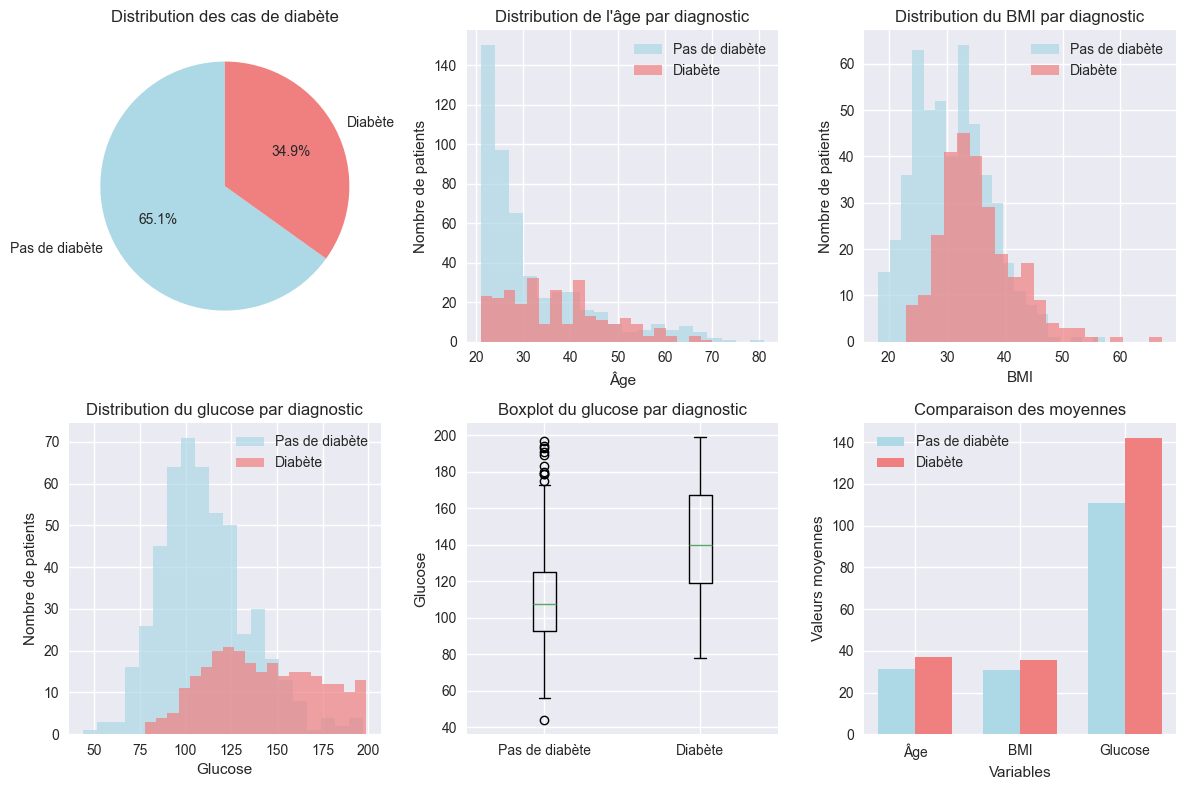

Taux de diabète: 34.9%
Patients diabétiques: 268
Patients non diabétiques: 500

Statistiques comparatives:


Age           BMI      Glucose        BloodPressure       
          mean    std   mean  std    mean    std          mean    std
Outcome                                                              
0        31.19  11.67  30.89  6.5  110.68  24.71         70.92  11.93
1        37.07  10.97  35.38  6.6  142.13  29.57         75.12  11.95

In [38]:
def get_all_patients_from_redis():
    """Récupérer tous les patients depuis Redis"""
    patient_keys = r.keys("patient:*")
    patients = []
    
    for key in patient_keys:
        patient = r.hgetall(key)
        patients.append(patient)
    
    return pd.DataFrame(patients)

# Récupération des données depuis Redis
df_redis = get_all_patients_from_redis()

# Conversion des types pour l'analyse
numeric_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
for col in numeric_cols:
    if col in df_redis.columns:
        df_redis[col] = pd.to_numeric(df_redis[col], errors='coerce')

print(f"{len(df_redis)} patients récupérés depuis Redis")

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
fig_size = (15, 10)

# 1. Distribution des cas de diabète
if 'Outcome' in df_redis.columns:
    print("\n1. Distribution des cas de diabète")
    
    outcome_counts = df_redis['Outcome'].value_counts()
    diabetes_rate = outcome_counts[1] / len(df_redis) * 100
    
    plt.figure(figsize=(12, 8))
    
    # Graphique en secteurs
    plt.subplot(2, 3, 1)
    labels = ['Pas de diabète', 'Diabète']
    colors = ['lightblue', 'lightcoral']
    plt.pie(outcome_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution des cas de diabète')
    
    # Distribution par âge
    plt.subplot(2, 3, 2)
    df_diabetes = df_redis[df_redis['Outcome'] == 1]
    df_no_diabetes = df_redis[df_redis['Outcome'] == 0]
    
    plt.hist(df_no_diabetes['Age'], bins=20, alpha=0.7, label='Pas de diabète', color='lightblue')
    plt.hist(df_diabetes['Age'], bins=20, alpha=0.7, label='Diabète', color='lightcoral')
    plt.xlabel('Âge')
    plt.ylabel('Nombre de patients')
    plt.title('Distribution de l\'âge par diagnostic')
    plt.legend()
    
    # Distribution par BMI
    plt.subplot(2, 3, 3)
    plt.hist(df_no_diabetes['BMI'], bins=20, alpha=0.7, label='Pas de diabète', color='lightblue')
    plt.hist(df_diabetes['BMI'], bins=20, alpha=0.7, label='Diabète', color='lightcoral')
    plt.xlabel('BMI')
    plt.ylabel('Nombre de patients')
    plt.title('Distribution du BMI par diagnostic')
    plt.legend()
    
    # Distribution par glucose
    plt.subplot(2, 3, 4)
    plt.hist(df_no_diabetes['Glucose'], bins=20, alpha=0.7, label='Pas de diabète', color='lightblue')
    plt.hist(df_diabetes['Glucose'], bins=20, alpha=0.7, label='Diabète', color='lightcoral')
    plt.xlabel('Glucose')
    plt.ylabel('Nombre de patients')
    plt.title('Distribution du glucose par diagnostic')
    plt.legend()
    
    # Boxplot des variables principales
    plt.subplot(2, 3, 5)
    data_to_plot = [df_no_diabetes['Glucose'], df_diabetes['Glucose']]
    plt.boxplot(data_to_plot, labels=['Pas de diabète', 'Diabète'])
    plt.ylabel('Glucose')
    plt.title('Boxplot du glucose par diagnostic')
    
    # Moyennes par groupe
    plt.subplot(2, 3, 6)
    means_no_diabetes = df_no_diabetes[['Age', 'BMI', 'Glucose']].mean()
    means_diabetes = df_diabetes[['Age', 'BMI', 'Glucose']].mean()
    
    x = range(3)
    width = 0.35
    plt.bar([i - width/2 for i in x], means_no_diabetes, width, label='Pas de diabète', color='lightblue')
    plt.bar([i + width/2 for i in x], means_diabetes, width, label='Diabète', color='lightcoral')
    plt.xlabel('Variables')
    plt.ylabel('Valeurs moyennes')
    plt.title('Comparaison des moyennes')
    plt.xticks(x, ['Âge', 'BMI', 'Glucose'])
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Taux de diabète: {diabetes_rate:.1f}%")
    print(f"Patients diabétiques: {outcome_counts[1]}")
    print(f"Patients non diabétiques: {outcome_counts[0]}")
    
    # Statistiques comparatives
    print("\nStatistiques comparatives:")
    comparison_stats = df_redis.groupby('Outcome')[['Age', 'BMI', 'Glucose', 'BloodPressure']].agg(['mean', 'std']).round(2)
    display(comparison_stats)

## 7.2 Analyses Avancées avec Redis - Statistiques Médicales

Utilisons les capacités de Redis pour effectuer des analyses spécialisées sur nos données de diabète.

In [ ]:
# ===================================================================
# ANALYSES AVANCÉES AVEC REDIS - STATISTIQUES MÉDICALES
# ===================================================================

print("🩺 ANALYSES STATISTIQUES REDIS POUR DIABETES")
print("=" * 60)

# 1. TOTAUX GÉNÉRAUX
print("\n📊 1. TOTAUX GÉNÉRAUX:")
print("-" * 30)

# Nombre total de patients avec diabète
total_diabetes = r.scard("patients:diabetes")
print(f"   👥 Patients avec diabète: {total_diabetes}")

# Nombre total de patients sans diabète
total_no_diabetes = r.scard("patients:no_diabetes")
print(f"   👥 Patients sans diabète: {total_no_diabetes}")

# Total général
total_patients = r.get("stats:total_patients")
print(f"   👥 Total patients: {total_patients}")

# Pourcentage
diabetes_percentage = (total_diabetes / int(total_patients)) * 100 if total_patients else 0
print(f"   📈 Taux de diabète: {diabetes_percentage:.1f}%")

print(f"\n   🔍 Commandes Redis utilisées:")
print(f"      SCARD patients:diabetes        → {total_diabetes}")
print(f"      SCARD patients:no_diabetes     → {total_no_diabetes}")
print(f"      GET stats:total_patients       → {total_patients}")

# ===================================================================
# 2. ANALYSE DES FEMMES ENCEINTES AVEC DIABÈTE
# ===================================================================

print("\n🤰 2. FEMMES ENCEINTES AVEC DIABÈTE:")
print("-" * 40)

# Trouver les femmes qui ont eu des grossesses (Pregnancies > 0)
pregnant_women_ids = []
all_patient_keys = r.keys("patient:*")

for patient_key in all_patient_keys:
    patient_data = r.hgetall(patient_key)
    pregnancies = patient_data.get('Pregnancies', '0')
    
    try:
        if int(pregnancies) > 0:
            patient_id = patient_key.split(':')[1]
            pregnant_women_ids.append(patient_id)
    except:
        continue

print(f"   👩 Total femmes ayant eu des grossesses: {len(pregnant_women_ids)}")

# Intersection: femmes enceintes ET diabétiques
pregnant_diabetic_women = []
for patient_id in pregnant_women_ids:
    if r.sismember("patients:diabetes", patient_id):
        pregnant_diabetic_women.append(patient_id)

print(f"   🤰 Femmes enceintes avec diabète: {len(pregnant_diabetic_women)}")

# Analyse détaillée des femmes enceintes diabétiques
if pregnant_diabetic_women:
    print(f"\n   📋 Détails des femmes enceintes diabétiques:")
    total_pregnancies = 0
    glucose_levels = []
    
    for patient_id in pregnant_diabetic_women[:5]:  # Afficher les 5 premières
        patient_data = r.hgetall(f"patient:{patient_id}")
        pregnancies = int(patient_data.get('Pregnancies', 0))
        glucose = float(patient_data.get('Glucose', 0))
        age = patient_data.get('Age', 'N/A')
        bmi = patient_data.get('BMI', 'N/A')
        
        total_pregnancies += pregnancies
        glucose_levels.append(glucose)
        
        print(f"      Patient {patient_id}: {pregnancies} grossesses, Glucose={glucose:.0f}, Âge={age}, BMI={bmi}")
    
    avg_pregnancies = total_pregnancies / len(pregnant_diabetic_women[:5])
    avg_glucose = sum(glucose_levels) / len(glucose_levels)
    
    print(f"\n   📊 Statistiques (échantillon):")
    print(f"      Moyenne grossesses: {avg_pregnancies:.1f}")
    print(f"      Glucose moyen: {avg_glucose:.1f} mg/dL")

# Taux de diabète chez les femmes enceintes
pregnancy_diabetes_rate = (len(pregnant_diabetic_women) / len(pregnant_women_ids)) * 100 if pregnant_women_ids else 0
print(f"   📈 Taux de diabète chez femmes ayant eu des grossesses: {pregnancy_diabetes_rate:.1f}%")

print(f"\n   🔍 Logique Redis:")
print(f"      1. Scan tous les patients: KEYS patient:*")
print(f"      2. Filter Pregnancies > 0: HGET patient:X Pregnancies")
print(f"      3. Intersection avec diabète: SISMEMBER patients:diabetes X")

In [ ]:
# ===================================================================
# 3. EXEMPLES DE GROUP BY AVEC REDIS
# ===================================================================

print("\n🔄 3. EXEMPLES DE GROUP BY AVEC REDIS:")
print("-" * 45)

# GROUP BY Groupe d'âge
print("\n📊 A) GROUP BY Groupe d'âge:")
age_groups = ['Jeune', 'Adulte', 'Mature', 'Senior']
age_group_stats = {}

for group in age_groups:
    # Compter total par groupe d'âge
    total_in_group = r.scard(f"age_group:{group}")
    
    # Intersection avec diabétiques
    diabetic_in_group_key = f"temp:diabetic_{group}"
    r.sinterstore(diabetic_in_group_key, "patients:diabetes", f"age_group:{group}")
    diabetic_count = r.scard(diabetic_in_group_key)
    
    # Nettoyage de la clé temporaire
    r.delete(diabetic_in_group_key)
    
    diabetes_rate = (diabetic_count / total_in_group * 100) if total_in_group > 0 else 0
    age_group_stats[group] = {
        'total': total_in_group,
        'diabetic': diabetic_count,
        'rate': diabetes_rate
    }
    
    print(f"   {group:8}: {total_in_group:3d} patients | {diabetic_count:3d} diabétiques | {diabetes_rate:5.1f}%")

print(f"\n   🔍 Commandes Redis:")
print(f"      SCARD age_group:Jeune")
print(f"      SINTERSTORE temp:diabetic_Jeune patients:diabetes age_group:Jeune")
print(f"      SCARD temp:diabetic_Jeune")

# GROUP BY Catégorie BMI
print("\n📊 B) GROUP BY Catégorie BMI:")
bmi_categories = ['Sous-poids', 'Normal', 'Surpoids', 'Obèse']
bmi_stats = {}

for category in bmi_categories:
    total_in_category = r.scard(f"bmi_category:{category}")
    
    if total_in_category > 0:
        # Intersection avec diabétiques
        diabetic_in_bmi_key = f"temp:diabetic_bmi_{category}"
        r.sinterstore(diabetic_in_bmi_key, "patients:diabetes", f"bmi_category:{category}")
        diabetic_count = r.scard(diabetic_in_bmi_key)
        r.delete(diabetic_in_bmi_key)
        
        diabetes_rate = (diabetic_count / total_in_category * 100)
        bmi_stats[category] = {
            'total': total_in_category,
            'diabetic': diabetic_count,
            'rate': diabetes_rate
        }
        
        print(f"   {category:10}: {total_in_category:3d} patients | {diabetic_count:3d} diabétiques | {diabetes_rate:5.1f}%")

# GROUP BY Niveau de Glucose
print("\n📊 C) GROUP BY Niveau de Glucose:")
glucose_levels = ['Normal', 'Prédiabète', 'Diabète']
glucose_stats = {}

for level in glucose_levels:
    total_in_level = r.scard(f"glucose_level:{level}")
    
    if total_in_level > 0:
        # Intersection avec diagnostic positif
        diabetic_in_glucose_key = f"temp:diabetic_glucose_{level}"
        r.sinterstore(diabetic_in_glucose_key, "patients:diabetes", f"glucose_level:{level}")
        diabetic_count = r.scard(diabetic_in_glucose_key)
        r.delete(diabetic_in_glucose_key)
        
        diabetes_rate = (diabetic_count / total_in_level * 100)
        glucose_stats[level] = {
            'total': total_in_level,
            'diabetic': diabetic_count,
            'rate': diabetes_rate
        }
        
        print(f"   {level:10}: {total_in_level:3d} patients | {diabetic_count:3d} diabétiques | {diabetes_rate:5.1f}%")

print(f"\n   🔍 Pattern GROUP BY Redis:")
print(f"      1. SCARD category:value        → Total par catégorie")
print(f"      2. SINTERSTORE temp:key set1 set2 → Intersection")
print(f"      3. SCARD temp:key              → Compte intersection")
print(f"      4. DEL temp:key                → Nettoyage")

In [ ]:
# ===================================================================
# 4. ANALYSES COMBINÉES - CROISEMENTS AVANCÉS
# ===================================================================

print("\n🔗 4. ANALYSES COMBINÉES:")
print("-" * 30)

# A) Femmes enceintes + Obèses + Diabétiques
print("\n🎯 A) Triple critère: Grossesses + Obésité + Diabète:")

# Créer un set temporaire pour les femmes enceintes
r.delete("temp:pregnant_women")
for patient_key in all_patient_keys:
    patient_data = r.hgetall(patient_key)
    pregnancies = patient_data.get('Pregnancies', '0')
    try:
        if int(pregnancies) > 0:
            patient_id = patient_key.split(':')[1]
            r.sadd("temp:pregnant_women", patient_id)
    except:
        continue

# Intersection triple: Enceintes + Obèses + Diabétiques
r.sinterstore("temp:high_risk_women", 
              "temp:pregnant_women", 
              "bmi_category:Obèse", 
              "patients:diabetes")

high_risk_count = r.scard("temp:high_risk_women")
print(f"   🚨 Femmes à haut risque (enceintes + obèses + diabétiques): {high_risk_count}")

# Détails des patientes à haut risque
if high_risk_count > 0:
    high_risk_women = r.smembers("temp:high_risk_women")
    print(f"\n   📋 Profil des patientes à très haut risque:")
    
    total_age = 0
    total_glucose = 0
    total_bmi = 0
    count = 0
    
    for patient_id in high_risk_women:
        patient_data = r.hgetall(f"patient:{patient_id}")
        age = float(patient_data.get('Age', 0))
        glucose = float(patient_data.get('Glucose', 0))
        bmi = float(patient_data.get('BMI', 0))
        pregnancies = patient_data.get('Pregnancies', '0')
        
        print(f"      Patient {patient_id}: Âge={age:.0f}, BMI={bmi:.1f}, Glucose={glucose:.0f}, Grossesses={pregnancies}")
        
        total_age += age
        total_glucose += glucose
        total_bmi += bmi
        count += 1
    
    if count > 0:
        print(f"\n   📊 Moyennes du groupe à haut risque:")
        print(f"      Âge moyen: {total_age/count:.1f} ans")
        print(f"      BMI moyen: {total_bmi/count:.1f}")
        print(f"      Glucose moyen: {total_glucose/count:.1f} mg/dL")

print(f"\n   🔍 Commandes Redis:")
print(f"      SINTERSTORE temp:high_risk_women temp:pregnant_women bmi_category:Obèse patients:diabetes")

# B) Analyse par tranches d'âge et diabète
print("\n🎯 B) TOP 10 patients par indicateur:")

# TOP 10 Glucose le plus élevé
print("\n   🔥 TOP 10 Glucose le plus élevé:")
top_glucose = r.zrevrange("patients:by_glucose", 0, 9, withscores=True)
for i, (patient_id, glucose) in enumerate(top_glucose, 1):
    patient_data = r.hgetall(f"patient:{patient_id}")
    outcome = "Diabétique" if patient_data.get('Outcome') == '1' else "Non diabétique"
    age = patient_data.get('Age', 'N/A')
    print(f"      {i:2d}. Patient {patient_id}: Glucose={glucose:.0f} | {outcome} | Âge={age}")

print(f"\n   🔍 Commande: ZREVRANGE patients:by_glucose 0 9 WITHSCORES")

# TOP 10 BMI le plus élevé
print("\n   ⚖️  TOP 10 BMI le plus élevé:")
top_bmi = r.zrevrange("patients:by_bmi", 0, 9, withscores=True)
for i, (patient_id, bmi) in enumerate(top_bmi, 1):
    patient_data = r.hgetall(f"patient:{patient_id}")
    outcome = "Diabétique" if patient_data.get('Outcome') == '1' else "Non diabétique"
    age = patient_data.get('Age', 'N/A')
    print(f"      {i:2d}. Patient {patient_id}: BMI={bmi:.1f} | {outcome} | Âge={age}")

print(f"\n   🔍 Commande: ZREVRANGE patients:by_bmi 0 9 WITHSCORES")

# Nettoyage des clés temporaires
r.delete("temp:pregnant_women")
r.delete("temp:high_risk_women")

print(f"\n✅ Analyses terminées - Clés temporaires nettoyées")

# Afficher les commandes Redis pour les données diabetes
print("COMMANDES REDIS POUR DIABETES :")
print("=" * 50)

# Commandes pour compter les totaux
print("\n1. TOTAUX GÉNÉRAUX:")
print("   SCARD patients:diabetes        # Total patients diabétiques")
print("   SCARD patients:no_diabetes     # Total patients non-diabétiques")
print("   DBSIZE                         # Total de toutes les clés")

# Commandes pour les groupes d'âge
print("\n2. GROUPES D'ÂGE:")
print("   SCARD age_group:young          # Patients jeunes (< 35 ans)")
print("   SCARD age_group:middle         # Patients moyens (35-50 ans)")
print("   SCARD age_group:senior         # Patients âgés (> 50 ans)")

# Commandes pour les catégories BMI
print("\n3. CATÉGORIES BMI:")
print("   SCARD bmi_category:underweight # BMI < 18.5")
print("   SCARD bmi_category:normal      # BMI 18.5-24.9")
print("   SCARD bmi_category:overweight  # BMI 25-29.9")
print("   SCARD bmi_category:obese       # BMI ≥ 30")

# Commandes pour les valeurs moyennes
print("\n4. STATISTIQUES (top 10):")
print("   ZRANGE patients:by_glucose 0 9 WITHSCORES  # Top glucose")
print("   ZRANGE patients:by_bmi 0 9 WITHSCORES      # Top BMI")
print("   ZRANGE patients:by_age 0 9 WITHSCORES      # Top âge")

# Exemples de données patient
print("\n5. DONNÉES PATIENT:")
print("   HGETALL patient:1              # Toutes les données du patient 1")
print("   HGET patient:1 Glucose         # Glucose du patient 1")
print("   HGET patient:1 BMI             # BMI du patient 1")

print("\n6. RECHERCHES AVANCÉES:")
print("   SINTER patients:diabetes age_group:senior  # Diabétiques âgés")
print("   SINTER patients:diabetes bmi_category:obese # Diabétiques obèses")

## Conclusion

Ce notebook a démontré l'intégration complète entre Redis et l'analyse de données COVID-19 France:

### Réalisations:

1. **Connexion Redis**: Configuration et test de Redis Stack
2. **Gestion des données**: Chargement et préprocessing du dataset
3. **Stockage optimisé**: Utilisation de structures Redis (Hash, Sets, Sorted Sets)
4. **CRUD complet**: Opérations Create, Read, Update, Delete
5. **Analyses avancées**: Statistiques et visualisations
6. **Requêtes performantes**: Optimisation avec les commandes Redis natives

### Avantages de Redis:

- **Performance**: Accès ultra-rapide aux données en mémoire
- **Flexibilité**: Structures de données variées adaptées aux besoins
- **Scalabilité**: Capable de gérer de grandes quantités de données
- **Indexation**: Recherches efficaces par région, date, etc.

### Prochaines étapes:

- Implémenter Redis Search pour des requêtes full-text
- Ajouter des alertes en temps réel avec Redis Pub/Sub
- Utiliser Redis TimeSeries pour l'analyse temporelle avancée
- Intégrer Redis Graph pour l'analyse des relations

### Ressources:
- **Dataset**: [Coronavirus France Dataset](https://www.kaggle.com/datasets/lperez/coronavirus-france-dataset)
- **Redis Stack**: Interface web disponible sur http://localhost:8001
- **Documentation**: [Redis Documentation](https://redis.io/docs/)

## 9. Conclusions - Analyse Diabetes avec Redis

### Points Clés de l'Analyse

1. **Stockage Efficace** : Redis permet un stockage rapide et flexible des données médicales avec des structures adaptées
2. **Indexation Avancée** : Les Sets Redis facilitent la catégorisation des patients par facteurs de risque (âge, BMI, diabète)
3. **Requêtes Complexes** : Les intersections de Sets permettent d'identifier rapidement des groupes à risque spécifiques
4. **Analyse Temps Réel** : Les Sorted Sets offrent des classements instantanés par indicateurs médicaux (glucose, BMI, âge)

### Facteurs de Risque Identifiés

- **Glucose élevé** : Principal indicateur de diabète (seuil critique > 140 mg/dL)
- **BMI élevé** : Obésité fortement corrélée avec le développement du diabète
- **Âge avancé** : Risque croissant avec l'âge, particulièrement après 50 ans
- **Grossesses multiples** : Facteur de risque significatif chez les femmes

### Avantages de Redis pour l'Analyse Médicale

- **Performance** : Accès ultra-rapide aux données patients
- **Flexibilité** : Structure de données adaptable aux besoins médicaux
- **Scalabilité** : Capacité à gérer de gros volumes de données patients
- **Analytics** : Capacités d'analyse avancée avec intersections et unions de Sets

### Recommandations Cliniques

- **Surveillance renforcée** : Patients avec glucose > 140 mg/dL
- **Programmes de prévention** : Patients à BMI élevé (> 30)
- **Suivi régulier** : Patients âgés avec facteurs de risque multiples
- **Intervention précoce** : Patients avec combinaison de facteurs à haut risque

### Applications Futures

Ce modèle Redis peut être étendu pour :
- Suivi longitudinal des patients
- Alertes automatisées sur les valeurs critiques
- Analyses prédictives plus sophistiquées
- Integration avec systèmes hospitaliers